cpu
torch.Size([9, 3, 64, 64])


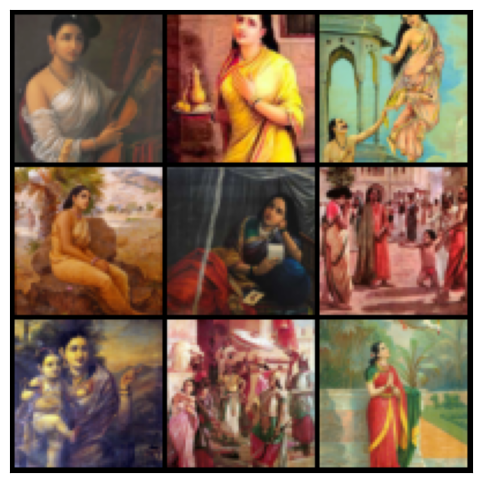

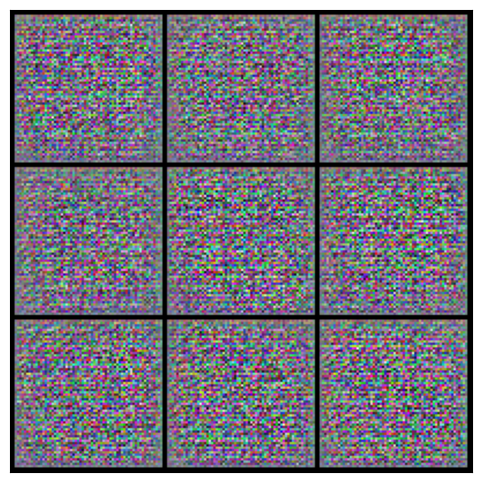

In [6]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import random
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch


# Set the device
device = torch.device('mps')

# Set the directories
sample_dir = '/Users/xavier/Desktop/projectgen503'
os.makedirs(sample_dir, exist_ok=True)
data_dir = '/Users/xavier/Desktop/project2'

# Set the image parameters
image_size = 64
batch_size = 9
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define the dataset and dataloader
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images):
    images = images.cpu()  # Move tensor to CPU
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()), nrow=3).permute(1, 2, 0))

def show_batch(dl):
    images, _ = next(iter(dl))
    show_images(images)

show_batch(train_dl)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    """Return the GPU device if available, else return CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to the device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator
discriminator = nn.Sequential(
   nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.AdaptiveAvgPool2d(1),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

# Generator
latent_size = 128
generator = nn.Sequential(
     nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)
generator = to_device(generator, device)

xb = torch.randn(batch_size, latent_size, 1, 1).to(device)  # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0000.png


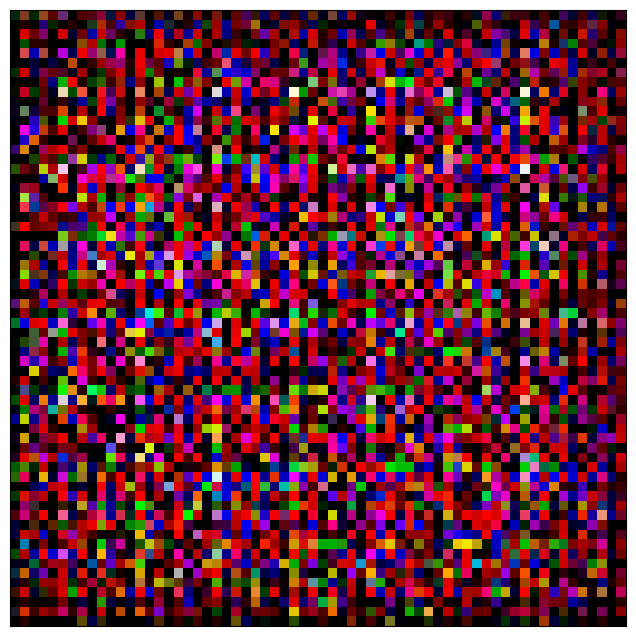

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0001.png


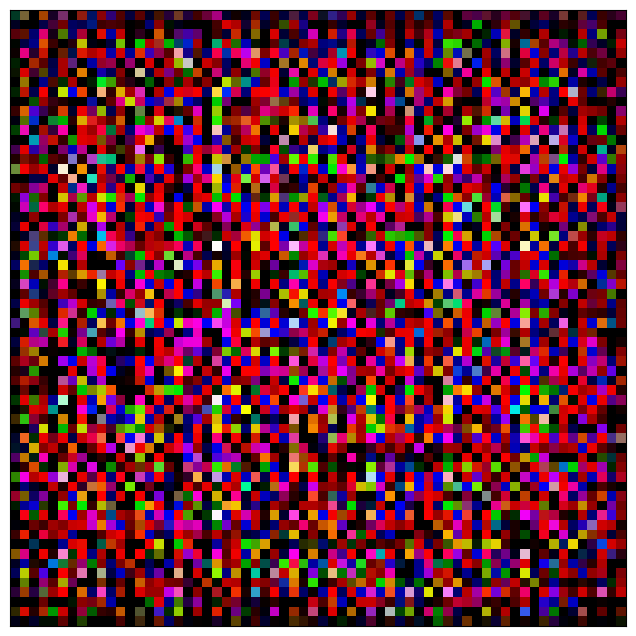

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0002.png


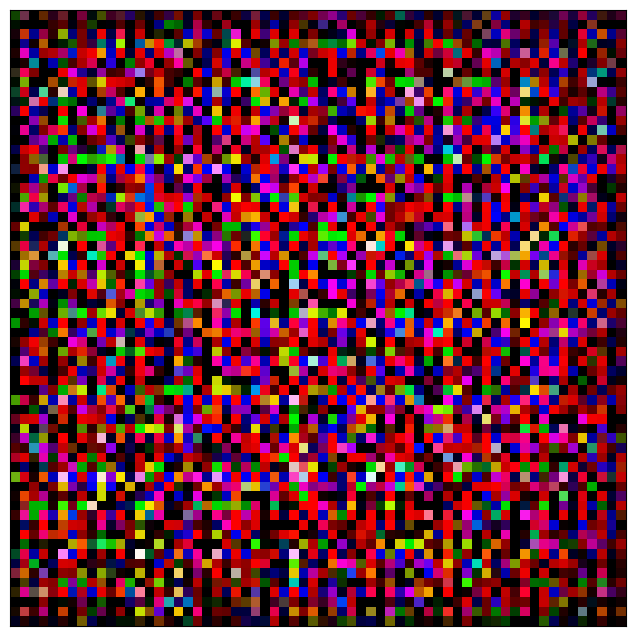

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0003.png


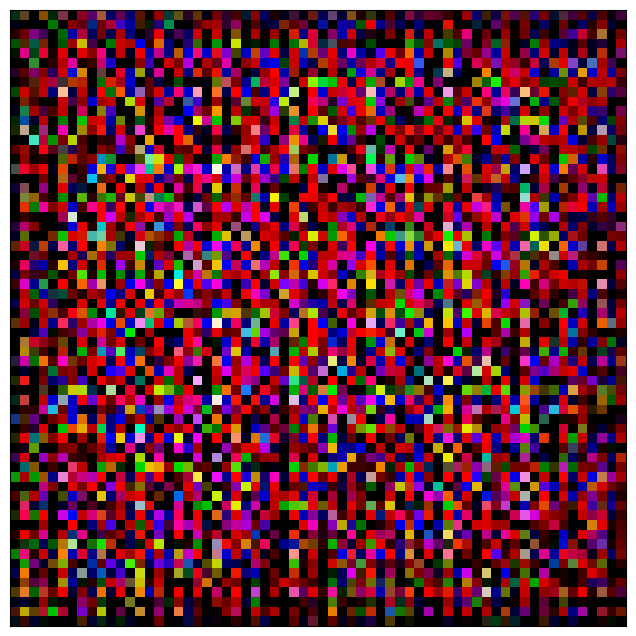

Saving generated-image-0004.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


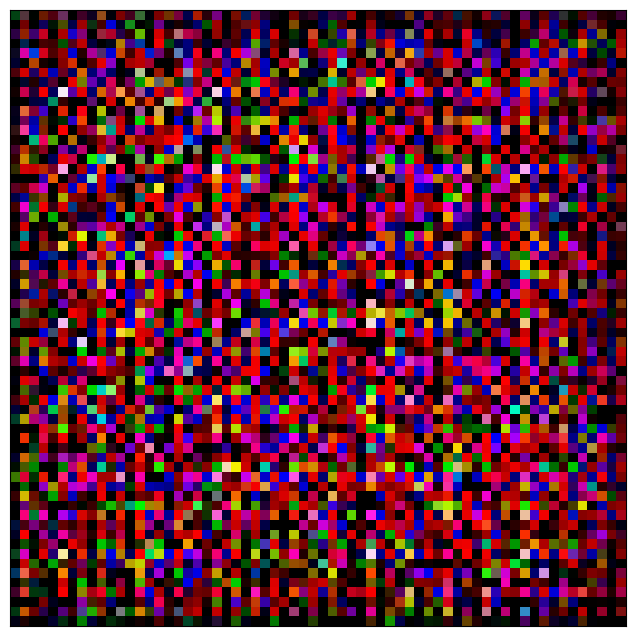

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0005.png


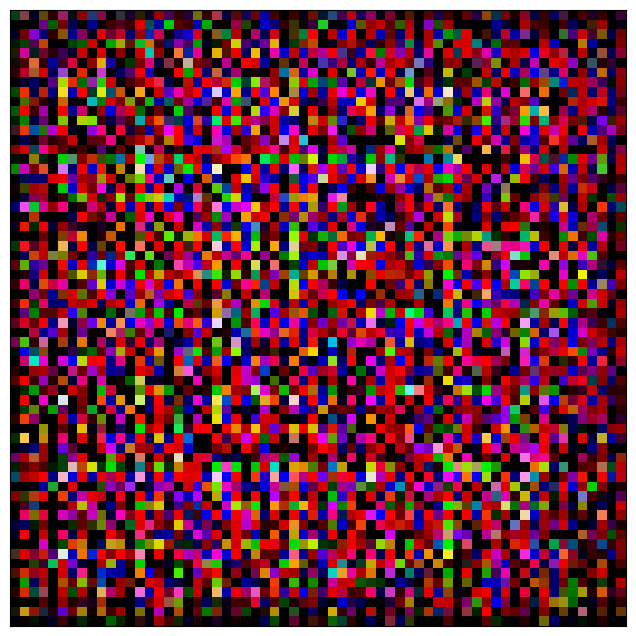

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0006.png


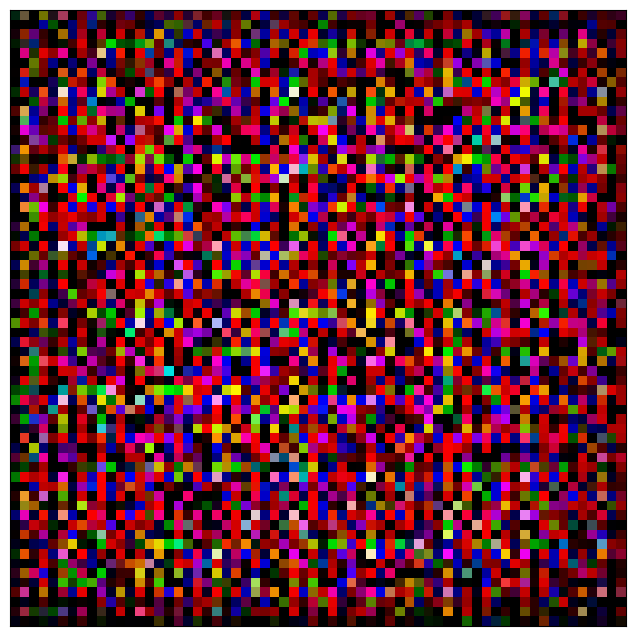

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0007.png


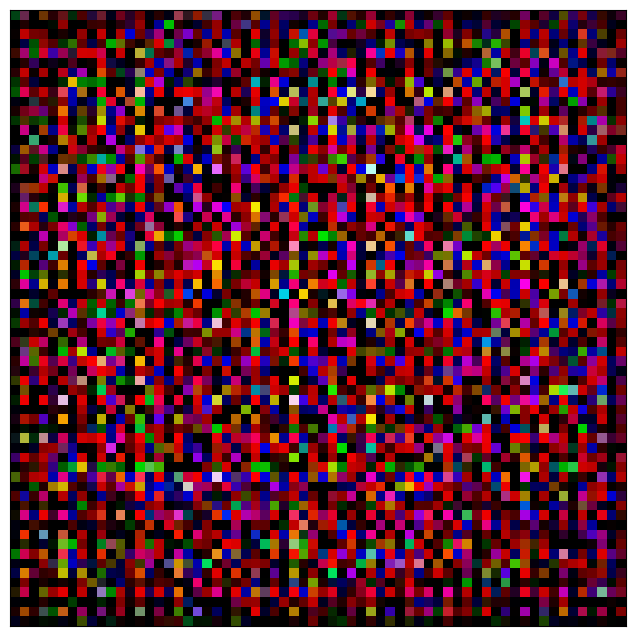

Saving generated-image-0008.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


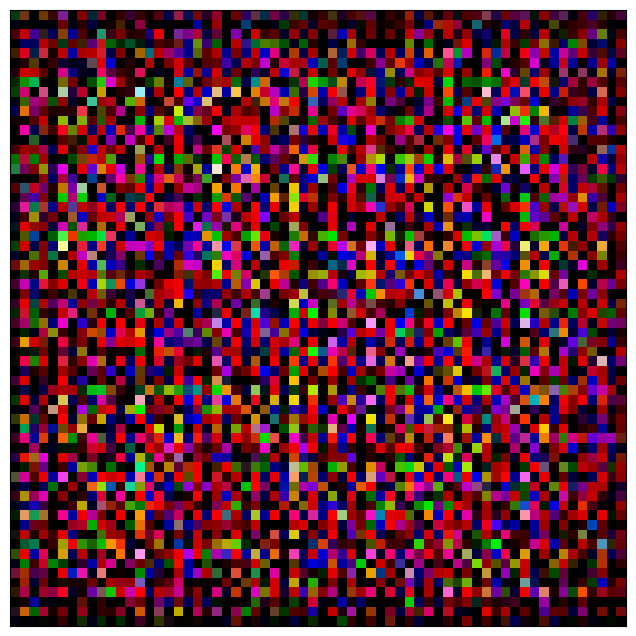

In [2]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(real_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images.detach())  # Detach fake_images to prevent generator gradient updates
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    
    # Create a new folder for the current epoch
    epoch_folder = os.path.join(sample_dir, f'epoch_{index:0=4d}')
    os.makedirs(epoch_folder, exist_ok=True)
    
    for i, fake_image in enumerate(fake_images):
        fake_fname = f'generated-image-{i:0=4d}.png'
        save_image(denorm(fake_image), os.path.join(epoch_folder, fake_fname))
        print('Saving', fake_fname)
        
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(fake_image.cpu().detach().permute(1, 2, 0))
            plt.show()



fixed_latent = torch.randn(9, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [3]:
def fit(epochs, lr, start_idx=1):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Calculate the number of iterations per epoch
    iterations_per_epoch = min(len(train_dl), 150 // batch_size)
    
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(tqdm(train_dl)):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
            # Break the loop if reached the desired number of iterations per epoch
            if i >= iterations_per_epoch:
                break
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

fixed_latent = torch.randn(9, latent_size, 1, 1, device=device)
fit(115, lr=0.0002, start_idx=1)


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/115], loss_g: 8.4258, loss_d: 1.1650, real_score: 0.7908, fake_score: 0.5336
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/115], loss_g: 11.4575, loss_d: 3.0215, real_score: 0.8195, fake_score: 0.9273
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/115], loss_g: 11.7922, loss_d: 2.6875, real_score: 0.9634, fake_score: 0.9153
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/115], loss_g: 4.9256, loss_d: 0.1771, real_score: 0.8812, fake_score: 0.0420
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/115], loss_g: 10.9909, loss_d: 0.0699, real_score: 0.9331, fake_score: 0.0001
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/115], loss_g: 9.1460, loss_d: 0.3547, real_score: 0.9938, fake_score: 0.2868
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/115], loss_g: 6.8452, loss_d: 0.1224, real_score: 0.9496, fake_score: 0.0664
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/115], loss_g: 3.6257, loss_d: 0.5098, real_score: 0.7325, fake_score: 0.1089
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/115], loss_g: 4.0041, loss_d: 0.3062, real_score: 0.9688, fake_score: 0.2225
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/115], loss_g: 5.2162, loss_d: 0.5811, real_score: 0.8534, fake_score: 0.2983
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/115], loss_g: 3.3241, loss_d: 0.1847, real_score: 0.8827, fake_score: 0.0523
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/115], loss_g: 4.6461, loss_d: 0.3504, real_score: 0.8480, fake_score: 0.1432
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/115], loss_g: 4.4858, loss_d: 1.0392, real_score: 0.8080, fake_score: 0.4812
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/115], loss_g: 4.0839, loss_d: 0.5063, real_score: 0.7169, fake_score: 0.0917
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/115], loss_g: 1.5246, loss_d: 0.5947, real_score: 0.6300, fake_score: 0.0385
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [16/115], loss_g: 5.2646, loss_d: 0.5018, real_score: 0.8618, fake_score: 0.1797
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [17/115], loss_g: 3.4576, loss_d: 0.5315, real_score: 0.7626, fake_score: 0.0660
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [18/115], loss_g: 3.9728, loss_d: 0.2012, real_score: 0.8663, fake_score: 0.0483
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [19/115], loss_g: 2.6772, loss_d: 0.5043, real_score: 0.7031, fake_score: 0.1111
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [20/115], loss_g: 3.0680, loss_d: 0.6524, real_score: 0.7599, fake_score: 0.2238
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [21/115], loss_g: 4.0250, loss_d: 0.2694, real_score: 0.8654, fake_score: 0.0995
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [22/115], loss_g: 4.3288, loss_d: 0.8250, real_score: 0.6888, fake_score: 0.1938
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [23/115], loss_g: 6.1266, loss_d: 1.3774, real_score: 0.3464, fake_score: 0.0015
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [24/115], loss_g: 5.6257, loss_d: 0.3494, real_score: 0.9263, fake_score: 0.2339
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [25/115], loss_g: 5.0914, loss_d: 0.4619, real_score: 0.7733, fake_score: 0.1177
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [26/115], loss_g: 11.6113, loss_d: 0.9238, real_score: 0.9848, fake_score: 0.5372
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [27/115], loss_g: 3.0236, loss_d: 0.1489, real_score: 0.8869, fake_score: 0.0214
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [28/115], loss_g: 6.3117, loss_d: 0.3161, real_score: 0.7783, fake_score: 0.0207
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [29/115], loss_g: 4.7303, loss_d: 0.1505, real_score: 0.9302, fake_score: 0.0702
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [30/115], loss_g: 8.2775, loss_d: 0.9922, real_score: 0.9513, fake_score: 0.4422
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [31/115], loss_g: 5.8051, loss_d: 0.2081, real_score: 0.8656, fake_score: 0.0357
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [32/115], loss_g: 3.3733, loss_d: 0.1804, real_score: 0.9137, fake_score: 0.0794
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [33/115], loss_g: 3.0276, loss_d: 0.1150, real_score: 0.9149, fake_score: 0.0168
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [34/115], loss_g: 3.3138, loss_d: 0.1399, real_score: 0.9201, fake_score: 0.0517
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [35/115], loss_g: 4.5018, loss_d: 0.2090, real_score: 0.9725, fake_score: 0.1600
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [36/115], loss_g: 5.7293, loss_d: 0.3034, real_score: 0.7750, fake_score: 0.0130
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [37/115], loss_g: 5.9916, loss_d: 0.2396, real_score: 0.9147, fake_score: 0.1269
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [38/115], loss_g: 2.8045, loss_d: 0.4521, real_score: 0.8873, fake_score: 0.2302
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [39/115], loss_g: 3.2363, loss_d: 0.6159, real_score: 0.6477, fake_score: 0.0644
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [40/115], loss_g: 6.0855, loss_d: 0.9527, real_score: 0.9615, fake_score: 0.3226
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [41/115], loss_g: 7.5585, loss_d: 0.2245, real_score: 0.8174, fake_score: 0.0074
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [42/115], loss_g: 6.0482, loss_d: 0.4830, real_score: 0.8178, fake_score: 0.1972
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [43/115], loss_g: 8.3202, loss_d: 1.1332, real_score: 0.9898, fake_score: 0.5001
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [44/115], loss_g: 5.0235, loss_d: 0.0849, real_score: 0.9932, fake_score: 0.0734
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [45/115], loss_g: 6.1357, loss_d: 0.1487, real_score: 0.9774, fake_score: 0.0943
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [46/115], loss_g: 5.8151, loss_d: 0.3427, real_score: 0.7538, fake_score: 0.0353
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [47/115], loss_g: 6.0946, loss_d: 0.5246, real_score: 0.8674, fake_score: 0.2511
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [48/115], loss_g: 4.8211, loss_d: 0.1053, real_score: 0.9663, fake_score: 0.0664
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [49/115], loss_g: 2.2002, loss_d: 0.6421, real_score: 0.6897, fake_score: 0.0451
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [50/115], loss_g: 5.1281, loss_d: 0.2375, real_score: 0.9388, fake_score: 0.1508
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [51/115], loss_g: 3.6749, loss_d: 0.1913, real_score: 0.8757, fake_score: 0.0217
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [52/115], loss_g: 6.8696, loss_d: 0.0749, real_score: 0.9441, fake_score: 0.0157
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [53/115], loss_g: 6.0075, loss_d: 0.1225, real_score: 0.9000, fake_score: 0.0077
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [54/115], loss_g: 6.5853, loss_d: 0.6973, real_score: 0.7504, fake_score: 0.2403
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [55/115], loss_g: 6.5150, loss_d: 0.2897, real_score: 0.8109, fake_score: 0.0598
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [56/115], loss_g: 3.0477, loss_d: 0.4757, real_score: 0.8034, fake_score: 0.1932
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [57/115], loss_g: 7.7095, loss_d: 0.2219, real_score: 0.9528, fake_score: 0.1367
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [58/115], loss_g: 5.2937, loss_d: 0.1311, real_score: 0.9143, fake_score: 0.0382
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [59/115], loss_g: 3.1227, loss_d: 0.3097, real_score: 0.8061, fake_score: 0.0751
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [60/115], loss_g: 4.4942, loss_d: 0.0805, real_score: 0.9893, fake_score: 0.0666
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [61/115], loss_g: 4.5099, loss_d: 0.1823, real_score: 0.8916, fake_score: 0.0517
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [62/115], loss_g: 9.2200, loss_d: 0.1103, real_score: 0.9006, fake_score: 0.0006
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [63/115], loss_g: 4.5865, loss_d: 0.3696, real_score: 0.8360, fake_score: 0.0194
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [64/115], loss_g: 5.9103, loss_d: 0.6555, real_score: 0.6920, fake_score: 0.0515
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [65/115], loss_g: 5.8904, loss_d: 0.2230, real_score: 0.9905, fake_score: 0.1805
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [66/115], loss_g: 4.0634, loss_d: 0.2000, real_score: 0.9636, fake_score: 0.1390
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [67/115], loss_g: 3.7741, loss_d: 0.0754, real_score: 0.9949, fake_score: 0.0660
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [68/115], loss_g: 3.9106, loss_d: 0.1927, real_score: 0.9831, fake_score: 0.1384
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [69/115], loss_g: 8.0769, loss_d: 0.1973, real_score: 0.8733, fake_score: 0.0093
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [70/115], loss_g: 5.3717, loss_d: 0.0831, real_score: 0.9922, fake_score: 0.0686
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [71/115], loss_g: 6.0636, loss_d: 0.3131, real_score: 0.8452, fake_score: 0.1066
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [72/115], loss_g: 4.8335, loss_d: 0.1140, real_score: 0.9914, fake_score: 0.0935
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [73/115], loss_g: 4.8851, loss_d: 0.1041, real_score: 0.9375, fake_score: 0.0378
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [74/115], loss_g: 9.8615, loss_d: 0.3656, real_score: 0.9837, fake_score: 0.2720
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [75/115], loss_g: 6.1962, loss_d: 0.2585, real_score: 0.8126, fake_score: 0.0018
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [76/115], loss_g: 7.0597, loss_d: 0.4801, real_score: 0.8776, fake_score: 0.1806
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [77/115], loss_g: 5.8076, loss_d: 0.1006, real_score: 0.9120, fake_score: 0.0036
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [78/115], loss_g: 3.9254, loss_d: 0.4802, real_score: 0.7053, fake_score: 0.0102
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [79/115], loss_g: 6.4819, loss_d: 0.0794, real_score: 0.9751, fake_score: 0.0512
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [80/115], loss_g: 6.2541, loss_d: 0.2420, real_score: 0.8983, fake_score: 0.0969
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [81/115], loss_g: 6.1311, loss_d: 0.0806, real_score: 0.9260, fake_score: 0.0020
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [82/115], loss_g: 9.2323, loss_d: 0.0775, real_score: 0.9283, fake_score: 0.0018
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [83/115], loss_g: 12.4442, loss_d: 0.0580, real_score: 0.9500, fake_score: 0.0052
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [84/115], loss_g: 6.7036, loss_d: 0.1753, real_score: 0.9948, fake_score: 0.1483
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [85/115], loss_g: 8.6187, loss_d: 0.0519, real_score: 0.9780, fake_score: 0.0283
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [86/115], loss_g: 4.9891, loss_d: 0.4006, real_score: 0.7528, fake_score: 0.0230
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [87/115], loss_g: 7.4941, loss_d: 0.1552, real_score: 0.9811, fake_score: 0.1222
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [88/115], loss_g: 5.9819, loss_d: 0.1120, real_score: 0.9467, fake_score: 0.0533
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [89/115], loss_g: 7.6949, loss_d: 0.0092, real_score: 0.9944, fake_score: 0.0036
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [90/115], loss_g: 3.9086, loss_d: 0.2257, real_score: 0.8922, fake_score: 0.0821
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [91/115], loss_g: 4.1525, loss_d: 0.0665, real_score: 0.9970, fake_score: 0.0591
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [92/115], loss_g: 8.9674, loss_d: 0.1410, real_score: 0.9979, fake_score: 0.1189
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [93/115], loss_g: 6.0707, loss_d: 0.0533, real_score: 0.9956, fake_score: 0.0475
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [94/115], loss_g: 5.7531, loss_d: 0.0986, real_score: 0.9396, fake_score: 0.0326
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [95/115], loss_g: 5.2180, loss_d: 0.1045, real_score: 0.9089, fake_score: 0.0053
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [96/115], loss_g: 8.7959, loss_d: 0.1366, real_score: 0.8813, fake_score: 0.0005
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [97/115], loss_g: 10.5428, loss_d: 0.4109, real_score: 0.9599, fake_score: 0.1814
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [98/115], loss_g: 6.4420, loss_d: 0.0190, real_score: 0.9845, fake_score: 0.0032
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [99/115], loss_g: 10.7252, loss_d: 0.0101, real_score: 0.9905, fake_score: 0.0005
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [100/115], loss_g: 6.1759, loss_d: 0.0995, real_score: 0.9359, fake_score: 0.0222
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [101/115], loss_g: 5.7196, loss_d: 0.7658, real_score: 0.5440, fake_score: 0.0003
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [102/115], loss_g: 6.7426, loss_d: 0.0343, real_score: 0.9713, fake_score: 0.0044
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [103/115], loss_g: 6.7697, loss_d: 0.1846, real_score: 0.8704, fake_score: 0.0043
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [104/115], loss_g: 4.7326, loss_d: 0.0361, real_score: 0.9774, fake_score: 0.0124
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [105/115], loss_g: 6.8380, loss_d: 0.3853, real_score: 0.8157, fake_score: 0.1099
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [106/115], loss_g: 8.3434, loss_d: 0.0113, real_score: 0.9963, fake_score: 0.0074
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [107/115], loss_g: 5.5664, loss_d: 0.0359, real_score: 0.9832, fake_score: 0.0181
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [108/115], loss_g: 8.0883, loss_d: 0.2169, real_score: 0.8325, fake_score: 0.0018
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [109/115], loss_g: 6.3343, loss_d: 0.0356, real_score: 0.9676, fake_score: 0.0007
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [110/115], loss_g: 8.6251, loss_d: 0.0057, real_score: 0.9975, fake_score: 0.0032
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [111/115], loss_g: 3.3305, loss_d: 0.0300, real_score: 0.9815, fake_score: 0.0108
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [112/115], loss_g: 6.0485, loss_d: 0.0437, real_score: 0.9810, fake_score: 0.0234
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [113/115], loss_g: 7.8334, loss_d: 0.0818, real_score: 0.9905, fake_score: 0.0644
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [114/115], loss_g: 9.5763, loss_d: 0.1005, real_score: 0.9776, fake_score: 0.0723
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [115/115], loss_g: 8.1575, loss_d: 0.1057, real_score: 0.9620, fake_score: 0.0584
Saving generated-image-0000.png
Saving generated-image-0001.png
Saving generated-image-0002.png
Saving generated-image-0003.png
Saving generated-image-0004.png
Saving generated-image-0005.png
Saving generated-image-0006.png
Saving generated-image-0007.png
Saving generated-image-0008.png


([8.425849914550781,
  11.4574556350708,
  11.792229652404785,
  4.925568580627441,
  10.990864753723145,
  9.145983695983887,
  6.84515380859375,
  3.62572979927063,
  4.004137992858887,
  5.216218948364258,
  3.324064016342163,
  4.646080017089844,
  4.485811233520508,
  4.083869934082031,
  1.5245975255966187,
  5.26459264755249,
  3.4576148986816406,
  3.972832202911377,
  2.677229881286621,
  3.067967176437378,
  4.024954795837402,
  4.328840255737305,
  6.126574516296387,
  5.625683307647705,
  5.091411113739014,
  11.61134147644043,
  3.0235753059387207,
  6.3116583824157715,
  4.730342388153076,
  8.277543067932129,
  5.805116653442383,
  3.3732974529266357,
  3.0276362895965576,
  3.313755512237549,
  4.501839637756348,
  5.7292938232421875,
  5.991556167602539,
  2.8045129776000977,
  3.2363457679748535,
  6.085514545440674,
  7.558481693267822,
  6.048200607299805,
  8.320230484008789,
  5.023542404174805,
  6.135663986206055,
  5.815053462982178,
  6.094564437866211,
  4.82